In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

In [2]:
def get_sub_fldrs(path):
    folders = []
    for folder in os.listdir(path):
        if os.path.isdir(
            os.path.join(path, folder)
        ):
            # Get absolute path of folder
            abs_path = os.path.abspath(os.path.join(path, folder))
            folders.append(abs_path)
    return folders

def get_opts_from_fldr(fname):
    """
    Given a folder name of the form:
        'scheme_name_re_1e-3_mu_1e-3'
    return a dictionary of the form:
        {'scheme': 'name', 're': '1e-3', 'mu': '1e-3'}
    """
    fname = os.path.basename(fname)
    opts = {}
    temp = fname.split('_')
    # All even indices are keys, and all odd indices are values
    for i in range(0, len(temp), 2):
        opts[temp[i]] = temp[i+1]
    return opts

def get_master_dict(main_dict):
    """
    Given a list of dictionaries, return a dictionary of the form:
        {'key1': [val1, val2, ...], 'key2': [val1, val2, ...], ...}
    """
    master_dict = {}
    for d in main_dict:
        for key, val in d.items():
            if key not in master_dict:
                master_dict[key] = [val]
            else:
                master_dict[key].append(val)
    # Remove duplicate values
    for key, val in master_dict.items():
        master_dict[key] = list(set(val))
        
    return master_dict
    
def get_results_file(path):
    for file in os.listdir(path):
        if file.endswith('results.npz'):
            return os.path.join(path, file)

def select_subfolder(subfolders, **kwargs):
    """
    Given a list of subfolders, and a dictionary of the form:
        {'key1': val1, 'key2': val2, ...}
    return a list of subfolders that match the criteria.
    Example:
        select_subfolder(folders, re='100')
    """
    selected = []
    # if no kwargs are given, return all folders
    if len(kwargs) == 0:
        return subfolders
    for fldr in subfolders:
        opts = get_opts_from_fldr(fldr)
        for key, val in kwargs.items():
            if key not in opts:
                raise ValueError('Key not found in folder name')
            if opts[key] == val:
                selected.append(fldr)
    return selected


In [38]:
def plotter(parent_dir, plot_type, **kwargs):
    plot_types = ['decay', 'l1', 'linf', 'p_l1', 'ke']
    if plot_type not in plot_types:
        raise ValueError(
            f'Invalid plot type: {plot_type}. Valid types are: {plot_types}'
        )
    subfolders = get_sub_fldrs(parent_dir)
    subfolders = select_subfolder(subfolders, **kwargs)
    plot_exact = False
    plt.figure(figsize=(8, 6))
    for folder in subfolders:
        results_file = get_results_file(folder)
        if results_file:
            data = np.load(results_file)
            t = data['t']
            plt_label = os.path.basename(folder)
            
            if plot_type == 'decay':
                if not plot_exact:
                    plt.semilogy(t, data['decay_ex'], 'k--', label='Exact')
                    plot_exact = True
                plt.semilogy(t, data['decay'], label=plt_label)
            elif plot_type == 'l1':
                plt.plot(t, data['l1'], label=plt_label)
            elif plot_type == 'linf':
                plt.plot(t, data['linf'], label=plt_label)
            elif plot_type == 'p_l1':
                plt.plot(t, data['p_l1'], label=plt_label)
            elif plot_type == 'ke':
                if not plot_exact:
                    # plt.plot(t, data['ke_ex'], 'k--', label='Exact')
                    plot_exact = True
                plt.plot(t, data['ke'], label=plt_label)

                # Plot local maximas as dots
                maxima = argrelextrema(data['ke'], np.greater)
                plt.plot(t[maxima], data['ke'][maxima], 'o')
                plt.annotate(
                    f'(t={t[maxima][0]:.2f}, ke={data["ke"][maxima][0]:.2f})',
                    (t[maxima][0], data['ke'][maxima][0]),
                    xytext=(t[maxima][0], data['ke'][maxima][0])
                )
    
    if plot_type == 'ke':
        plt.ylim(0, 0.4)
        plt.grid()

    plt.title(plot_type)
    plt.xlabel('t')
    plt.legend()
    plt.show()

In [39]:
fldrs = get_sub_fldrs('outputs/temp_tgv')
fldrs = get_sub_fldrs('outputs/tgv_external_forcing_colagrossi2021')
temp = [get_opts_from_fldr(fldr) for fldr in fldrs]
master_dict = get_master_dict(temp)
master_dict, select_subfolder(fldrs, re='200')

({'nx': ['400', '100', '200'],
  're': ['50000', '1000000', '10000', '100000', '1000'],
  'tf': ['6.0', '3.0', '2.0']},
 [])

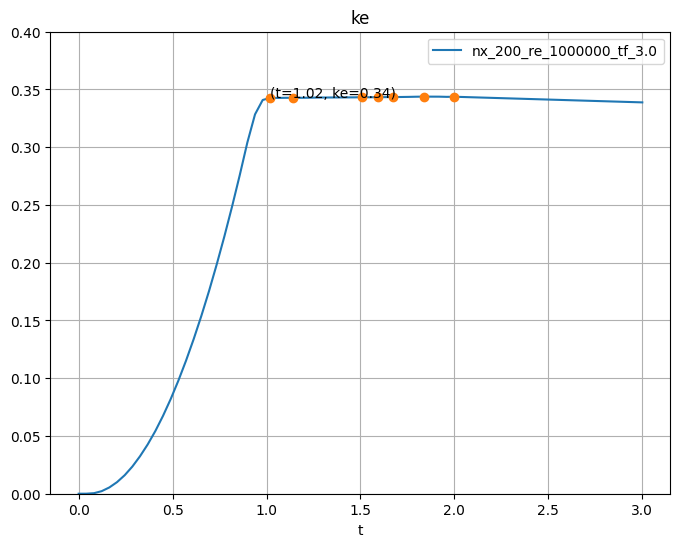

In [45]:
# plotter('outputs/temp_tgv', 'ke', re='1000')
plotter('outputs/tgv_external_forcing_colagrossi2021', 'ke', re=str(1_000_000))

In [6]:
# plot_type_options = ['decay', 'l1', 'linf', 'p_l1', 'ke']
# interact(
#     plotter,
#     parent_dir='outputs/temp_tgv',
#     plot_type=plot_type_options,
#     # re=master_dict['re'],
# )